# ESE 5390 Project Code



The provided project starter code walks through a comparative study of three post-training pruning methods:



* **Global Weight Pruning**

* **Layer-wise Weight Pruning**

* **Layer-wise Output Channel Pruning**



Following this starter code, you will further enhance the **efficiency and accuracy** of layer-wise channel pruning by implementing one of the two advanced techniques:



* **Training-Aware Pruning:**

    Apply regularization during training to promote sparsity. Refer to Wen et al.’s _"Learning Structured Sparsity in Deep Neural Networks"_, though you are encouraged to explore other regularization techniques.



* **Iterative Pruning:**

    Repeatedly prune and retrain the network to restore accuracy. You may refer to Han et al.’s _"Deep Compression: Compressing Deep Neural Networks with Pruning, Trained Quantization, and Huffman Coding."_ However, feel free to develop innovative variations of this approach.



The grading will reflect how well you understand the literature, design and execute experiments, present your findings, and document your project in a comprehensive technical report.



 **Bonus points** are available for extending the project scope through additional explorations (see **Bonus Opportunities**).



## Environment



We strongly recommend using GPU or TPU to avoid excessive runtimes.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
import torchvision
import time
import numpy as np
import copy
import sys
import os
from torchvision import datasets, models, transforms
from pathlib import Path
import random
import matplotlib.pyplot as plt

print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)
Path("./data").mkdir(parents=True, exist_ok=True)
data_dir = Path('./data')
net_fn = Path('./net')


# see if gdown is already downloaded
try:
    import gdown
    print("gdown is already installed, skipping installing command to save time......")
except ImportError:
    !conda install -y gdown


# Seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

PyTorch Version:  2.4.0
Torchvision Version:  0.19.0
Retrieving notices: ...working... done
Channels:
 - rapidsai
 - nvidia
 - nodefaults
 - conda-forge
 - defaults
 - pytorch
Platform: linux-64
Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-24.11.0              |  py310hff52083_0         907 KB  conda-forge
    filelock-3.16.1            |     pyhd8ed1ab_0          17 KB  conda-forge
    gdown-5.2.0                |     pyhd8ed1ab_0          21 KB  conda-forge
    openssl-3.4.0              |       hb9d3cd8_0         2.8 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.7 MB

The following NE

In [ ]:
print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)
Path("./data").mkdir(parents=True, exist_ok=True)
data_dir = Path('./data')
net_fn = Path('./net')

# see if gdown is already downloaded
try:
    import gdown
    print("gdown is already installed, skipping installing command to save time......")
except ImportError:
    !conda install -y gdown

PyTorch Version:  2.4.0
Torchvision Version:  0.19.0
gdown is already installed, skipping installing command to save time......


In [ ]:
REPOS = [
    [
        "1ZLyAcimq4sdZ0tl5yINudwSD843pAoOJ",
        "1EXwrSw6BWKMC4ovPRUyfuqeObuqsR-R5",
        "1rFIAJ9aLZrRCOeijo5mI0zWiEl3OMJ3j"
    ],
    [
        "1VLe11mOwsetC4IlL3wy8QexTat8XCool",
        "1_QwUcr3gmnjPFbKj0VrfOayVEWjRBS4Z",
        "1fgf9elhD7EhbKJn2NMnQS1iwQXesQZ3g"
    ],
    [
        "1BKC4kCB9sbwfRuhrAJWVEmbLoHx2vJWC",
        "1qhrcYgGKRf3Wt8YDU6aVRhzJDFHeqerP",
        "1JXym04uAoNGGpkBRzIn0yStZmRX0SmNu"
    ]
]


FILES = [
    Path("./data/ILSVRC2012_devkit_t12.tar.gz"),
    Path("./data/ILSVRC2012_devkit_t3.tar.gz"),
    Path("./data/ILSVRC2012_img_val.tar")
]



# Shuffle the order of repos

random.seed(int(time.time()))
random.shuffle(REPOS)

for repo_index, repo in enumerate(REPOS):
    missing_files = [str(file) for file in FILES if not file.is_file()]
    if not missing_files:
        print("All files are present. Skipping further downloads.")
        break


    print(f"Attempting download from repo {repo_index}")
    print(f"Missing files: {missing_files}")


    for file, url in zip(FILES, repo):
        if not file.is_file():
            print(f"Downloading {file}...")
            !gdown "{url}" -O "{str(file)}"


missing_files = [str(file) for file in FILES if not file.is_file()]
if missing_files:
    print(f"Failed to download all files. Still missing: {missing_files}")
    print(f"Contact TA team through EdStem with the output of this code block!", file=sys.stderr)
else:
    print("All files successfully downloaded.")

Attempting download from repo 0
Missing files: ['data/ILSVRC2012_devkit_t12.tar.gz', 'data/ILSVRC2012_devkit_t3.tar.gz', 'data/ILSVRC2012_img_val.tar']
Downloading...
From: https://drive.google.com/uc?id=1VLe11mOwsetC4IlL3wy8QexTat8XCool
To: /kaggle/working/data/ILSVRC2012_devkit_t12.tar.gz
100%|███████████████████████████████████████| 2.57M/2.57M [00:00<00:00, 210MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_QwUcr3gmnjPFbKj0VrfOayVEWjRBS4Z
To: /kaggle/working/data/ILSVRC2012_devkit_t3.tar.gz
100%|██████████████████████████████████████| 22.4M/22.4M [00:00<00:00, 76.1MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1fgf9elhD7EhbKJn2NMnQS1iwQXesQZ3g
From (redirected): https://drive.google.com/uc?id=1fgf9elhD7EhbKJn2NMnQS1iwQXesQZ3g&confirm=t&uuid=cf91be06-a068-4632-bb07-d5177e002ff9
To: /kaggle/working/data/ILSVRC2012_img_val.tar
100%|██████████████████████████████████████| 6.74G/6.74G [01:08<00:00, 99.1MB/s]
All files are present. Skipping further downl

In [ ]:
# Clear output folder
import os

def remove_folder_contents(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                remove_folder_contents(file_path)
                os.rmdir(file_path)
        except Exception as e:
            print(e)

# folder_path = '/kaggle/working'
# remove_folder_contents(folder_path)
# os.rmdir(folder_path)

# os.remove("/kaggle/working/state.db")


In [ ]:
# Create transform to preprocess data

val_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create validation dataset
val_dataset = datasets.ImageNet('./data', split='val', transform=val_transform)

# Create validation dataloader
val_dataloader = torch.utils.data.DataLoader(val_dataset, shuffle=False, num_workers=2)

print(f'Number of validation images: {len(val_dataset)}')

Number of validation images: 50000


In [ ]:
# Put your reusable functions here.

# You can copy functions from previous labs and tutorials.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def evaluate(model, dataloader):
    correct = 0
    total = 0
    model.eval()
    model.to(device)

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

def collect_non_zero_channels(model):

    model.eval()
    model.to(device)
    non_zero_channels = []

    for layer in model.features:

        if isinstance(layer, nn.Conv2d):
            # Count non-zero channels
            non_zero_count = torch.sum(layer.weight.abs().sum(dim=[1, 2, 3]) > 0).item()
            non_zero_channels.append(non_zero_count)

    print(f"Non-zero channels collected: {non_zero_channels}")
    return non_zero_channels

def create_hardened_model(pruned_model, non_zero_channels):

    """
    Creates a new model with adjusted channels based on non-zero channels
    from a pruned model, and copies over the non-zero weights.
    """

    # Instantiate a new VGG16 model to modify
    hardened_model = models.vgg16(pretrained=False).to(device)

    # Track the previous layer's output channels for setting input channels of the next layer
    prev_out_channels = 3  # Initial input channels (for RGB images)
    conv_layer_idx = 0
    # Loop through the convolutional layers and replace with pruned versions
    for i, layer in enumerate(pruned_model.features):

        if isinstance(layer, nn.Conv2d):
            # Create a new Conv2d layer with updated in_channels and out_channels
            out_channels = non_zero_channels[conv_layer_idx]
            new_conv = nn.Conv2d(
                in_channels=prev_out_channels,
                out_channels=out_channels,
                kernel_size=layer.kernel_size,
                stride=layer.stride,
                padding=layer.padding,
                bias=(layer.bias is not None)
            )

            # Copy non-zero weights from pruned model to new layer
            new_conv.weight.data = layer.weight.data[:out_channels, :prev_out_channels, :, :].clone()
            if new_conv.bias is not None:
                new_conv.bias.data = layer.bias.data[:out_channels].clone()

            # Replace the layer in hardened_model
            hardened_model.features[i] = new_conv

            # Update prev_out_channels for the next layer
            prev_out_channels = out_channels
            conv_layer_idx += 1

        elif isinstance(layer, nn.MaxPool2d):
            # Keep MaxPool2d layers unchanged
            hardened_model.features[i] = layer


    # Adjust the first fully connected (linear) layer after convolutional layers
    # Compute input features for the first fully connected layer
    num_flatten_features = prev_out_channels * 7 * 7  # Assuming VGG16 has 7x7 spatial size before FC layers
    hardened_model.classifier[0] = nn.Linear(num_flatten_features, hardened_model.classifier[0].out_features).to(device)
    hardened_model.classifier[0].weight.data = pruned_model.classifier[0].weight.data[:, :num_flatten_features].clone()

    if hardened_model.classifier[0].bias is not None:
        hardened_model.classifier[0].bias.data = pruned_model.classifier[0].bias.data.clone()

    # Copy the remaining fully connected layers directly (unaffected by pruning)
    for i in range(1, len(hardened_model.classifier)):
        hardened_model.classifier[i] = pruned_model.classifier[i]

    return hardened_model


#  COUNT PARAMETERS
def count_params(model):

    model.to(device)
    tot_params = 0
    for layer_name, param in model.named_parameters():
        tot_params += torch.count_nonzero(param.data)

    return tot_params

def get_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    model_size = os.path.getsize("temp.p")/1e6
    os.remove('temp.p')
    return model_size

In [ ]:
# from google.colab import drive
# import pickle


# drive.mount('/content/drive')
# save_path = '/content/drive/MyDrive/ese539/project'


## 1. Global Weight Pruning



- Perform pruning using `prune.global_unstructured` on a pretrained VGG16 using various sparsity targets.

- The models should be pruned away at 5% increments from 5% to 45% total pruning of the model.

- Save a copy of each pruned model in a dictionary.

- Plot the top-1 accuracy against weight pruned from 0% to 45% (use the original VGG16 for 0%).

In [ ]:
orig_model = models.vgg16(pretrained=True)#TODO: load pretrained model
prune_rate_list = range(5, 50, 5) # List of prune rate to test from 5-45 inclusive with step of 5
global_pruning = {} # Dictionary to store global pruning results
orig_top1_acc = evaluate(orig_model, val_dataloader)
print(f'Original model top-1 accuracy: {orig_top1_acc}%')

for prune_rate in prune_rate_list:
    model = models.vgg16(pretrained=True) #TODO: load pretrained model
    parameters_to_prune = [(layer, 'weight') for layer in model.features if isinstance(layer, nn.Conv2d)]

    # parameter_to_prune = (
    #     (models.features[0], 'weight'), # conv1 of VGG16
    #     #TODO: Add more layers to prune
    # )

    #TODO: Prune model
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=prune_rate / 100  # Convert percentage to decimal
    )

    #TODO: make the pruning permanent to increase speed
    for layer, _ in parameters_to_prune:
        prune.remove(layer, 'weight')
    global_pruning[prune_rate] = {} # Dictionary to store accuracy results and model for each prune rate
    global_pruning[prune_rate]['model'] = model # Copy pruned model to dictionary
    # TODO Run validation on the pruned model
    top1_acc = evaluate(model, val_dataloader)
    global_pruning[prune_rate]['top1_acc'] = top1_acc # TODO fill with top1 accuracy
    global_pruning[prune_rate]['top1_acc_rel'] = top1_acc / orig_top1_acc * 100 # Percent accuracy compared to original model

    print(f'Top1 accuracy for prune amount {prune_rate}%: {global_pruning[prune_rate]["top1_acc"]}%')
    print(f'Top1 accuracy (rel) for prune amount {prune_rate}%: {global_pruning[prune_rate]["top1_acc_rel"]}%')

# TODO plot the results

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 195MB/s]


Original model top-1 accuracy: 71.516%
Top1 accuracy for prune amount 5%: 71.496%
Top1 accuracy (rel) for prune amount 5%: 99.97203423010234%
Top1 accuracy for prune amount 10%: 71.44%
Top1 accuracy (rel) for prune amount 10%: 99.89373007438894%
Top1 accuracy for prune amount 15%: 71.454%
Top1 accuracy (rel) for prune amount 15%: 99.91330611331728%
Top1 accuracy for prune amount 20%: 71.378%
Top1 accuracy (rel) for prune amount 20%: 99.80703618770625%
Top1 accuracy for prune amount 25%: 71.416%
Top1 accuracy (rel) for prune amount 25%: 99.86017115051176%
Top1 accuracy for prune amount 30%: 71.402%
Top1 accuracy (rel) for prune amount 30%: 99.84059511158343%
Top1 accuracy for prune amount 35%: 71.196%
Top1 accuracy (rel) for prune amount 35%: 99.55254768163766%
Top1 accuracy for prune amount 40%: 70.854%
Top1 accuracy (rel) for prune amount 40%: 99.07433301638792%
Top1 accuracy for prune amount 45%: 70.164%
Top1 accuracy (rel) for prune amount 45%: 98.10951395491917%


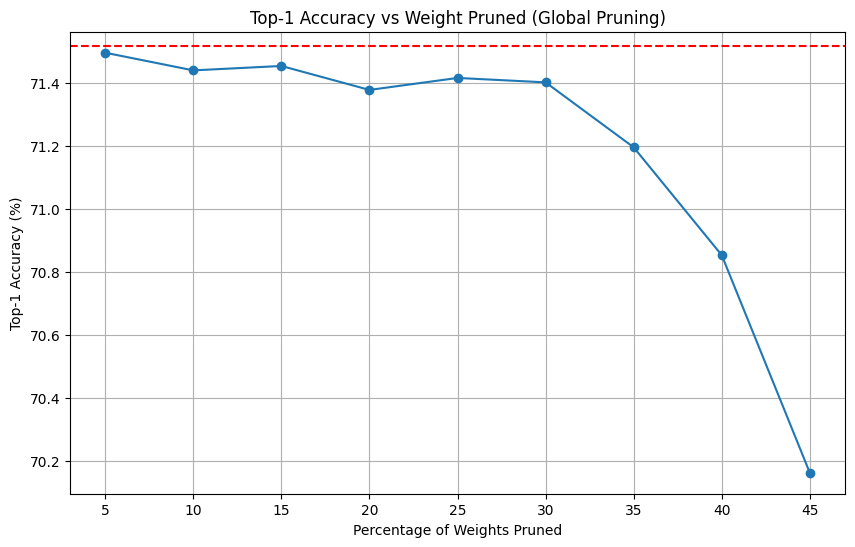

In [ ]:
prune_rates = list(global_pruning.keys())
top1_accuracies = [global_pruning[rate]['top1_acc'] for rate in prune_rates]

plt.figure(figsize=(10, 6))
plt.plot(prune_rates, top1_accuracies, marker='o', linestyle='-', label='Pruned Model')
plt.axhline(y=orig_top1_acc, color='r', linestyle='--', label='Original Model')
plt.title('Top-1 Accuracy vs Weight Pruned (Global Pruning)')
plt.xlabel('Percentage of Weights Pruned')
plt.ylabel('Top-1 Accuracy (%)')
plt.grid(True)
plt.show()

### Observations

- Accuracy Retention at Low Pruning Rates:

  - The top-1 accuracy remains close to the original VGG16 model's performance up to 30% pruning, indicating that globally removing less important weights has minimal impact on the model's representational capacity.

- Gradual Accuracy Decline:

  - Between 35% and 45% pruning, accuracy begins to decline. This suggests that beyond a certain sparsity level, important weights are being pruned, leading to reduced model performance.

- Moderate Loss at Higher Pruning:

  - Even at 45% pruning, the model retains a top-1 accuracy of approximately 70%, demonstrating that global pruning maintains resilience by distributing weight removal across all layers, avoiding excessive pruning in any single layer.

In [ ]:
# import pickle

# with open(f'./global_pruning.pkl', 'wb') as f:
#     pickle.dump(global_pruning, f)

In [ ]:
# from IPython.display import FileLink
# FileLink(r'global_pruning.pkl')

In [ ]:
# os.remove("/kaggle/working/global_pruning.pkl")

In [ ]:
del global_pruning

## 2. Layer-wise Weight Pruning



- Perform pruning using `prune.l1_unstructured` on each layer of pretrained VGG16 using various sparsity targets.

- Each layer should be pruned away at 5% increments from 5% to 45% total pruning of the model.

- Save a copy of each pruned model in a dictionary.

- Plot the top-1 accuracy against weight pruned from 0% to 45% (use the original VGG16 for 0%).

- What do you observe? Why does layer-wise pruning perform better/worse than global pruning?

In [ ]:
orig_model = models.vgg16(pretrained=True)#TODO: load pretrained model
prune_rate_list = range(5, 50, 5) # List of prune rate to test from 5-45 inclusive with step of 5
layer_pruning = {} # Dictionary to store layer pruning results
orig_top1_acc = evaluate(orig_model, val_dataloader)
print(f'Original model top-1 accuracy: {orig_top1_acc}%')

for prune_rate in prune_rate_list:

    model = models.vgg16(pretrained=True)#TODO: load pretrained model
    # convs_to_prune = () #TODO: Add conv layers to prune
    for layer in model.features:
        if isinstance(layer, nn.Conv2d):
            prune.l1_unstructured(layer, name='weight', amount=prune_rate / 100)
            prune.remove(layer, 'weight')

    # linears_to_prune = () #TODO: Add linear layers to prune
    for layer in model.classifier:
        if isinstance(layer, nn.Linear):
            prune.l1_unstructured(layer, name='weight', amount=prune_rate / 100)
            prune.remove(layer, 'weight')

    #TODO: Prune model

    layer_pruning[prune_rate] = {} # Dictionary to store accuracy results and model for each prune rate
    layer_pruning[prune_rate]['model'] = model # Copy pruned model to dictionary

    # TODO Run validation on the pruned model
    top1_acc = evaluate(model, val_dataloader)
    layer_pruning[prune_rate]['top1_acc'] = top1_acc # TODO fill with top1 accuracy
    layer_pruning[prune_rate]['top1_acc_rel'] = top1_acc / orig_top1_acc * 100 # Percent accuracy compared to original model

    print(f'Top1 accuracy for prune amount {prune_rate}%: {layer_pruning[prune_rate]["top1_acc"]}%')
    print(f'Top1 accuracy (rel) for prune amount {prune_rate}%: {layer_pruning[prune_rate]["top1_acc_rel"]}%')



# with open(f'./layer_pruning.pkl', 'wb') as f:
#     pickle.dump(layer_pruning, f)

# print(f'Dictionary saved to {save_path}')
# TODO plot the results

Original model top-1 accuracy: 71.516%
Top1 accuracy for prune amount 5%: 71.5%
Top1 accuracy (rel) for prune amount 5%: 99.97762738408188%
Top1 accuracy for prune amount 10%: 71.462%
Top1 accuracy (rel) for prune amount 10%: 99.92449242127636%
Top1 accuracy for prune amount 15%: 71.5%
Top1 accuracy (rel) for prune amount 15%: 99.97762738408188%
Top1 accuracy for prune amount 20%: 71.34%
Top1 accuracy (rel) for prune amount 20%: 99.75390122490072%
Top1 accuracy for prune amount 25%: 71.054%
Top1 accuracy (rel) for prune amount 25%: 99.35399071536439%
Top1 accuracy for prune amount 30%: 70.81%
Top1 accuracy (rel) for prune amount 30%: 99.01280832261313%
Top1 accuracy for prune amount 35%: 69.954%
Top1 accuracy (rel) for prune amount 35%: 97.81587337099388%
Top1 accuracy for prune amount 40%: 69.186%
Top1 accuracy (rel) for prune amount 40%: 96.74198780692433%
Top1 accuracy for prune amount 45%: 67.216%
Top1 accuracy (rel) for prune amount 45%: 93.98735947200625%


In [ ]:
# import pickle

# with open(f'./layer_pruning.pkl', 'wb') as f:
#     pickle.dump(layer_pruning, f)

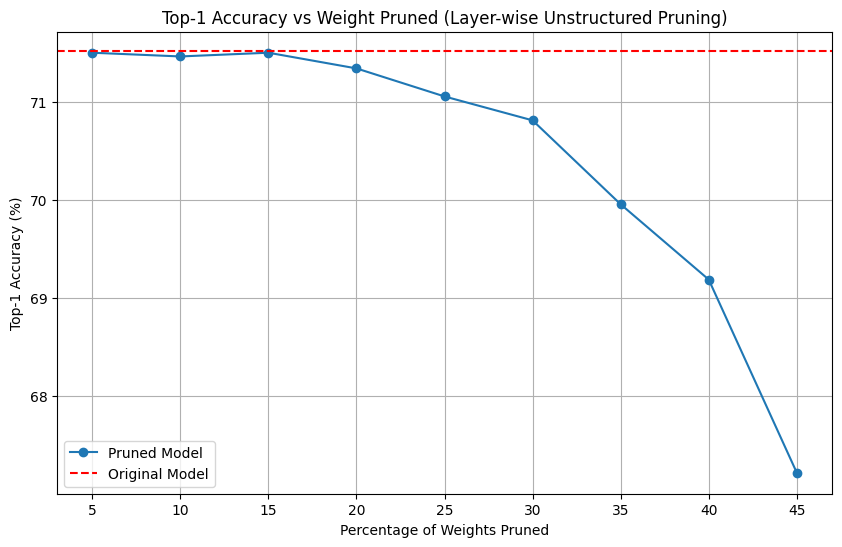

In [ ]:
prune_rates = list(layer_pruning.keys())
top1_accuracies = [layer_pruning[rate]['top1_acc'] for rate in prune_rates]


plt.figure(figsize=(10, 6))
plt.plot(prune_rates, top1_accuracies, marker='o', linestyle='-', label='Pruned Model')
plt.axhline(y=orig_top1_acc, color='r', linestyle='--', label='Original Model')
plt.title('Top-1 Accuracy vs Weight Pruned (Layer-wise Unstructured Pruning)')
plt.xlabel('Percentage of Weights Pruned')
plt.ylabel('Top-1 Accuracy (%)')
plt.grid(True)
plt.legend()
plt.show()

### Observations

- Accuracy Retention at Low Sparsity Levels (5% - 15%):

  - Layer-wise pruning retains accuracy close to the original model at lower pruning levels, as less significant weights are removed independently within each layer.
  - Balanced pruning ensures no specific layer is disproportionately affected, leading to minimal performance impact.

- Gradual Accuracy Decline (20% - 30%):

  - Beyond 15% pruning, accuracy begins to decline steadily as layers start losing their representational capacity.
  - Pruning higher percentages removes weights critical to feature extraction, reducing overall performance.

- Significant Drop at High Sparsity Levels (35% - 45%):

  - At higher pruning levels, accuracy drops sharply, with a noticeable drop to around 67% at 45% pruning.
  - Critical weights within layers are pruned, severely impacting performance.

### Comparison with Global Pruning

- Better at Low Sparsity: Layer-wise pruning ensures balanced pruning across layers, avoiding over-pruning in smaller or sensitive layers, leading to better accuracy than global pruning at lower sparsity levels (up to 15%).

- Worse at High Sparsity: Unlike global pruning, layer-wise pruning does not account for global weight importance, making it less effective at high sparsity levels. Global pruning achieves better accuracy at higher pruning rates by prioritizing global weight importance.

To conclude, layer-wise pruning excels at maintaining performance at low sparsity but underperforms compared to global pruning as pruning levels increase.

In [ ]:
# from IPython.display import FileLink
# FileLink(r'layer_pruning.pkl')

In [ ]:
# os.remove("/kaggle/working/layer_pruning.pkl")

In [ ]:
del layer_pruning

## 3. Layer-wise Output Channel Pruning



- Perform pruning using `prune.ln_structured` on each layer of pretrained VGG16 using various sparsity targets.

- Prune along the output channels for conv layers and output dimension for linear layers

- Do not prune the last linear layer to preserve the number of predicted classes

- Each layer should be pruned away at 5% increments from 5% to 45% total pruning of the model.

- Save a copy of each pruned model in a dictionary.

- Plot the top-1 accuracy against weight pruned from 0% to 45% (use the original VGG16 for 0%).

- What do you observe? Why does layer-wise channel pruning perform better/worse than layer-wise unstructured pruning?

In [ ]:
orig_model = models.vgg16(pretrained=True)#TODO: load pretrained model
prune_rate_list = range(5, 50, 5) # List of prune rate to test from 5-45 inclusive with step of 5
channel_pruning = {} # Dictionary to store channel pruning results
orig_top1_acc = evaluate(orig_model, val_dataloader)
print(f'Original model top-1 accuracy: {orig_top1_acc}%')

for prune_rate in prune_rate_list:
    model = models.vgg16(pretrained=True) #TODO: load pretrained model
    convs_to_prune = () #TODO: Add conv layers to prune

    for layer in model.features:
        if isinstance(layer, nn.Conv2d):
            prune.ln_structured(layer, name='weight', amount=prune_rate / 100, n=1, dim=0)
            prune.remove(layer, 'weight')

    linears_to_prune = () #TODO: Add linear layers to prune (except the last linear layer)

    for i, layer in enumerate(model.classifier):
        if isinstance(layer, nn.Linear) and i < len(model.classifier) - 1:
            prune.ln_structured(layer, name='weight', amount=prune_rate / 100, n=1, dim=0)
            prune.remove(layer, 'weight')

    #TODO: Prune model
    channel_pruning[prune_rate] = {} # Dictionary to store accuracy results and model for each prune rate
    channel_pruning[prune_rate]['model'] = model # Copy pruned model to dictionary

    # TODO Run validation on the pruned model
    top1_acc = evaluate(model, val_dataloader)
    channel_pruning[prune_rate]['top1_acc'] = top1_acc # TODO fill with top1 accuracy
    channel_pruning[prune_rate]['top1_acc_rel'] = top1_acc / orig_top1_acc * 100 # Percent accuracy compared to original model

    print(f'Top1 accuracy for prune amount {prune_rate}%: {channel_pruning[prune_rate]["top1_acc"]}%')
    print(f'Top1 accuracy (rel) for prune amount {prune_rate}%: {channel_pruning[prune_rate]["top1_acc_rel"]}%')


# print(f'Dictionary saved to {save_path}')

# TODO plot the results

Original model top-1 accuracy: 71.516%
Top1 accuracy for prune amount 5%: 64.872%
Top1 accuracy (rel) for prune amount 5%: 90.70977124000224%
Top1 accuracy for prune amount 10%: 49.978%
Top1 accuracy (rel) for prune amount 10%: 69.88366239722579%
Top1 accuracy for prune amount 15%: 24.636%
Top1 accuracy (rel) for prune amount 15%: 34.44823535991945%
Top1 accuracy for prune amount 20%: 9.092%
Top1 accuracy (rel) for prune amount 20%: 12.713238995469546%
Top1 accuracy for prune amount 25%: 2.772%
Top1 accuracy (rel) for prune amount 25%: 3.8760557078136353%
Top1 accuracy for prune amount 30%: 0.784%
Top1 accuracy (rel) for prune amount 30%: 1.096258179987695%
Top1 accuracy for prune amount 35%: 0.33%
Top1 accuracy (rel) for prune amount 35%: 0.4614352033111471%
Top1 accuracy for prune amount 40%: 0.17%
Top1 accuracy (rel) for prune amount 40%: 0.23770904412998486%
Top1 accuracy for prune amount 45%: 0.12%
Top1 accuracy (rel) for prune amount 45%: 0.16779461938587167%


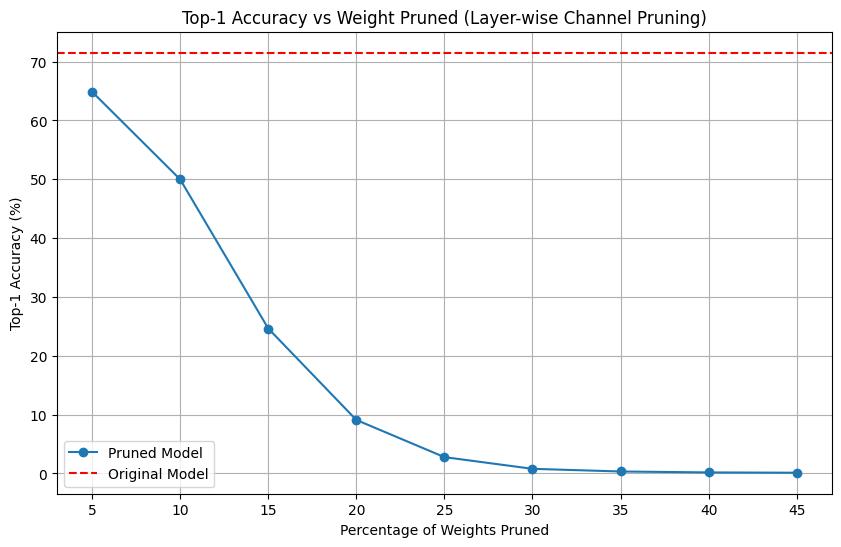

In [ ]:
prune_rates = list(channel_pruning.keys())
top1_accuracies = [channel_pruning[rate]['top1_acc'] for rate in prune_rates]

plt.figure(figsize=(10, 6))
plt.plot(prune_rates, top1_accuracies, marker='o', linestyle='-', label='Pruned Model')
plt.axhline(y=orig_top1_acc, color='r', linestyle='--', label='Original Model')
plt.title('Top-1 Accuracy vs Weight Pruned (Layer-wise Channel Pruning)')
plt.xlabel('Percentage of Weights Pruned')
plt.ylabel('Top-1 Accuracy (%)')
plt.grid(True)
plt.legend()
plt.show()

### Observations

- Accuracy Decline at Low Sparsity Levels (5% -10%):

  - Accuracy drops sharply even at low pruning rates, with significant degradation compared to unstructured pruning. This indicates the removal of entire feature maps (output channels) has a more severe impact on the model's representational capacity.

- Severe Performance Loss Beyond 10% Pruning:

  - Beyond 10% pruning, the model's accuracy declines drastically. By 25% pruning, the model loses most of its predictive power, indicating that removing entire output channels eliminates critical information.

### Comparison with Layer-Wise Unstructured Pruning:

- Worse Performance: Layer-wise channel pruning performs worse than unstructured pruning because removing entire output channels affects entire feature maps, whereas unstructured pruning removes individual weights without discarding full feature maps.

- Structured Sparsity: While channel pruning introduces structured sparsity (beneficial for efficiency and inference speed), it sacrifices accuracy significantly, especially without retraining.

To conclude, layer-wise channel pruning performs poorly compared to layer-wise unstructured pruning, as it aggressively reduces the network's ability to retain meaningful features, resulting in a sharper accuracy decline.

In [ ]:
# with open(f'./channel_pruning.pkl', 'wb') as f:
#     pickle.dump(channel_pruning, f)

In [ ]:
# from IPython.display import FileLink
# FileLink(r'channel_pruning.pkl')

In [ ]:
# os.remove("/kaggle/working/channel_pruning.pkl")

## 3.5 Layer-wise Output Channel Pruning (Continued)



In this section, we harden the channel pruning by removing the channels

- Collect the number of non-zero output channels for each layer after `prune.ln_structured`

- Instantiate a new model based on the number of non-zero output channels

- Remember that the input channels of next layer should match the output channels for current layer

- Pay special attention to the last convolution layer and first linear layer

- Copy over the the non-zero weights from the pruned model to the hardened model

- Calculate the run time and model size for the original VGG16 and the hardened VGG16s

- Plot the **relative** top-1 accuracy, run time and model size from 0% to 45% pruned VGG16

- What do you observe? What is the trade-off between accuracy, run time, and model size?

In [ ]:
# torch.cuda.empty_cache()

In [ ]:
# del global_pruning

In [ ]:
prune_rate_list = range(5, 50, 5) # List of prune rate to test from 5-45 inclusive with step of 5
hardened_pruning = {} # Dictionary to store hardened pruning results
orig_model = models.vgg16(pretrained=True)
st = time.time()
orig_top1_acc = evaluate(orig_model, val_dataloader)
end = time.time()
orig_runtime = end - st
orig_model_size = sum(param.numel() for param in orig_model.parameters())
orig_model_param_count = count_params(orig_model)
orig_model_size = get_size_of_model(orig_model)
print(f'Original model - Top-1 Accuracy: {orig_top1_acc}%, Model Size: {orig_model_size:.2f} MB, Runtime: {orig_runtime:.2f}s, Parameters count: {orig_model_param_count} parameters')

for prune_rate in prune_rate_list:
    #TODO: Collect the number of non-zero channels for each layer
    pruned_model = channel_pruning[prune_rate]['model']

    non_zero_channels = collect_non_zero_channels(pruned_model)

    #TODO: Instantiate a new model based on collected number of non-zero channels
    hardened_model = create_hardened_model(pruned_model, non_zero_channels)

    hardened_pruning[prune_rate] = {} # Dictionary to store accuracy results and model for each prune rate
    hardened_pruning[prune_rate]['model'] = hardened_model # Copy original model to dictionary

    st = time.time()
    top1_acc = evaluate(hardened_model, val_dataloader)
    end = time.time()
    hardened_runtime = end - st
    hardened_model_size = sum(param.numel() for param in hardened_model.parameters())
    hardened_model_param_count = count_params(hardened_model)
    hardened_model_size = get_size_of_model(hardened_model)
    hardened_pruning[prune_rate]['top1_acc'] = top1_acc # TODO fill with top1 accuracy
    hardened_pruning[prune_rate]['top1_acc_rel'] = top1_acc / orig_top1_acc * 100 # TODO Percent accuracy compared to original model
    hardened_pruning[prune_rate]['run_time'] = hardened_runtime # TODO Collect run time of the hardened model
    hardened_pruning[prune_rate]['run_time_rel'] = hardened_runtime / orig_runtime * 100 # TODO Collect run time (relative) of the hardened model
    hardened_pruning[prune_rate]['model_size'] = hardened_model_size # TODO Collect model size of the hardened model
    hardened_pruning[prune_rate]['model_size_rel'] = hardened_model_size / orig_model_size * 100 # TODO Collect model size (relative) of the hardened model
    hardened_pruning[prune_rate]['model_param_count'] = hardened_model_param_count # TODO Collect model param count of the hardened model
    hardened_pruning[prune_rate]['model_param_count_rel'] = hardened_model_param_count / orig_model_param_count * 100 # TODO Collect model param count (relative) of the hardened model

    print(f'For prune amount {prune_rate}% Top1 accuracy: {top1_acc}%; Model Size: {hardened_model_size:.2f} MB; Runtime: {hardened_runtime:.2f}s; Parameters: {hardened_model_param_count:.2f} parameters')
    print(f'For prune amount {prune_rate}% Top1 accuracy (rel): {hardened_pruning[prune_rate]["top1_acc_rel"]:.2f}%; Model Size (rel): {hardened_pruning[prune_rate]["model_size_rel"]:.2f}%; Runtime (rel): {hardened_pruning[prune_rate]["run_time_rel"]:.2f}%; Parametres (rel): {hardened_pruning[prune_rate]["model_param_count_rel"]:.2f}%')

# with open(f'./hardened_pruning.pkl', 'wb') as f:
    # pickle.dump(hardened_pruning, f)

# print(f'Dictionary saved to {save_path}')

Original model - Top-1 Accuracy: 71.516%, Model Size: 553.44 MB, Runtime: 349.34s, Parameters count: 138357544 parameters
Non-zero channels collected: [61, 61, 122, 122, 243, 243, 243, 486, 486, 486, 486, 486, 486]


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


For prune amount 5% Top1 accuracy: 45.79%; Model Size: 526.75 MB; Runtime: 344.97s; Parameters: 125308777.00 parameters
For prune amount 5% Top1 accuracy (rel): 64.03%; Model Size (rel): 95.18%; Runtime (rel): 98.75%; Parametres (rel): 90.57%
Non-zero channels collected: [58, 58, 115, 115, 230, 230, 230, 461, 461, 461, 461, 461, 461]
For prune amount 10% Top1 accuracy: 8.758%; Model Size: 501.33 MB; Runtime: 334.82s; Parameters: 113245469.00 parameters
For prune amount 10% Top1 accuracy (rel): 12.25%; Model Size (rel): 90.58%; Runtime (rel): 95.84%; Parametres (rel): 81.85%
Non-zero channels collected: [54, 54, 109, 109, 218, 218, 218, 435, 435, 435, 435, 435, 435]
For prune amount 15% Top1 accuracy: 0.774%; Model Size: 475.28 MB; Runtime: 312.50s; Parameters: 101669138.00 parameters
For prune amount 15% Top1 accuracy (rel): 1.08%; Model Size (rel): 85.88%; Runtime (rel): 89.45%; Parametres (rel): 73.48%
Non-zero channels collected: [51, 51, 102, 102, 205, 205, 205, 410, 410, 410, 410,

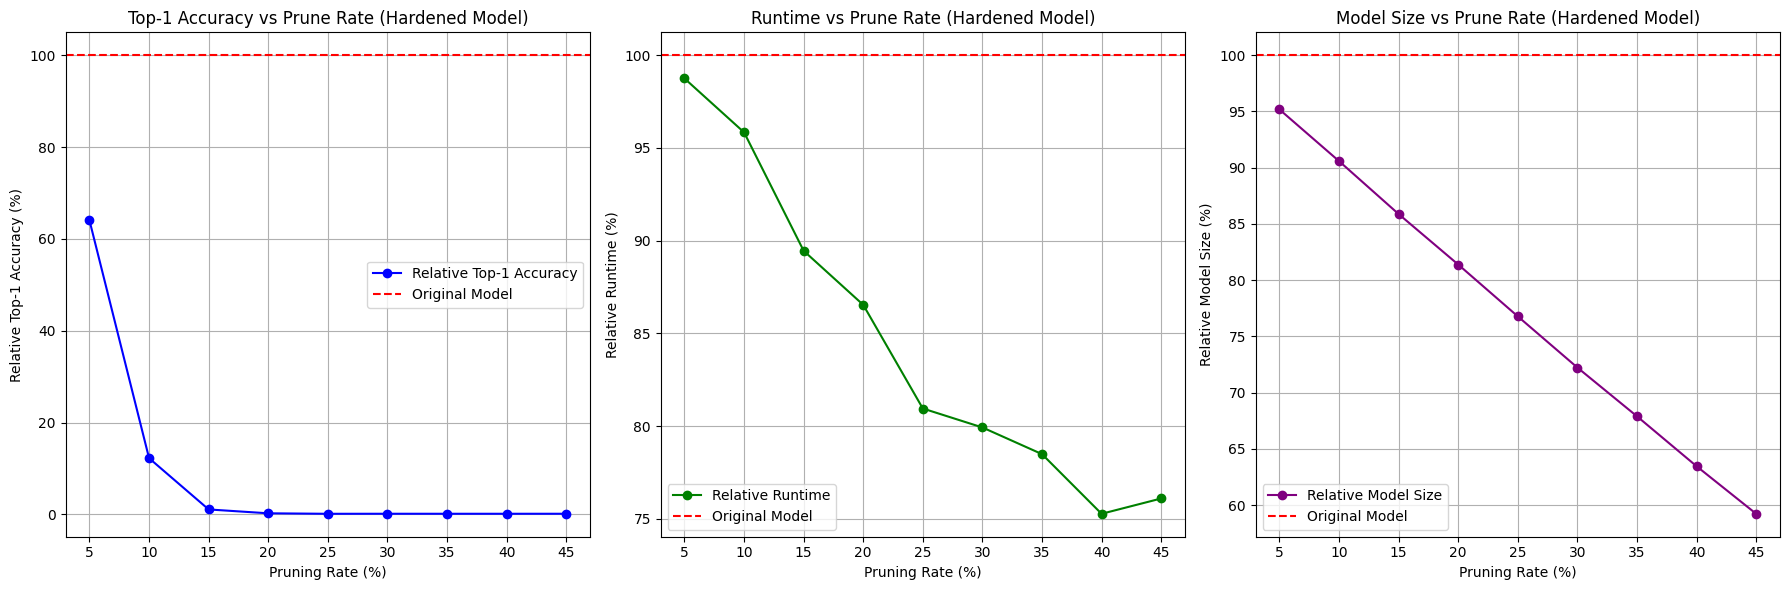

In [ ]:
#TODO plot the relative accuracy, relative run time, and relative model size
prune_rates = list(hardened_pruning.keys())
top1_accuracies = [
    value.cpu().item() if torch.is_tensor(value) else value
    for value in [hardened_pruning[rate]['top1_acc_rel'] for rate in prune_rates]
]
run_times = [
    value.cpu().item() if torch.is_tensor(value) else value
    for value in [hardened_pruning[rate]['run_time_rel'] for rate in prune_rates]
]
model_sizes = [
    value.cpu().item() if torch.is_tensor(value) else value
    for value in [hardened_pruning[rate]['model_size_rel'] for rate in prune_rates]
]


plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.plot(prune_rates, top1_accuracies, marker='o', linestyle='-', color='b', label='Relative Top-1 Accuracy')
plt.axhline(y=100, color='r', linestyle='--', label='Original Model')
plt.title('Top-1 Accuracy vs Prune Rate (Hardened Model)')
plt.xlabel('Pruning Rate (%)')
plt.ylabel('Relative Top-1 Accuracy (%)')
plt.grid(True)
plt.legend()


plt.subplot(1, 3, 2)
plt.plot(prune_rates, run_times, marker='o', linestyle='-', color='g', label='Relative Runtime')
plt.axhline(y=100, color='r', linestyle='--', label='Original Model')
plt.title('Runtime vs Prune Rate (Hardened Model)')
plt.xlabel('Pruning Rate (%)')
plt.ylabel('Relative Runtime (%)')
plt.grid(True)
plt.legend()


plt.subplot(1, 3, 3)
plt.plot(prune_rates, model_sizes, marker='o', linestyle='-', color='purple', label='Relative Model Size')
plt.axhline(y=100, color='r', linestyle='--', label='Original Model')
plt.title('Model Size vs Prune Rate (Hardened Model)')
plt.xlabel('Pruning Rate (%)')
plt.ylabel('Relative Model Size (%)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

### Observations

- Accuracy Decline:

  - The relative top-1 accuracy drops sharply at low pruning rates (5% - 10%) and becomes negligible beyond 15% pruning. This shows that permanently removing entire channels severely limits the model's ability to retain meaningful features without retraining.

- Runtime Improvements:

  - As pruning increases, runtime decreases steadily due to the structured sparsity introduced by hardened pruning. At 45% pruning, runtime is reduced to about 76% of the original, highlighting its efficiency for inference tasks.

- Model Size Reduction:

  - The relative model size decreases linearly with pruning, reaching less than 60% of the original size at 45% pruning. This demonstrates that hardened pruning effectively reduces storage requirements by directly removing unused channels.

### Trade-Off

- Efficiency vs. Performance:
  - While hardened pruning significantly reduces model size and runtime, making it suitable for deployment in resource-constrained environments, it leads to a steep accuracy decline, especially beyond 15% pruning. This trade-off makes the technique less favorable for tasks requiring high predictive performance unless retraining is performed.

In summary, hardened channel pruning provides substantial computational and storage efficiency gains but sacrifices accuracy, with its usability dependent on specific use-case requirements.

In [ ]:
# import pickle
# with open(f'./hardened_pruning.pkl', 'wb') as f:
#     pickle.dump(hardened_pruning, f)

In [ ]:
# from IPython.display import FileLink
# FileLink(r'hardened_pruning.pkl')

In [ ]:
# os.remove("/kaggle/working/hardened_pruning.pkl")

## 4. Training-Aware Pruning or Iterative Pruning

## 5. (Optional) Bonus Exploration